In [11]:
import numpy as np
import matplotlib.pyplot as plt

from rlop.env.edm import NumpyEDM1

In [12]:
from edm.edm import NumpyEDM1 as NE_orig
env_orig = NE_orig(1)

In [13]:
env = NumpyEDM1(1)

## sparking at place becomes less and less efficient due to debris

In [14]:
obs = [env.reset()]
ends = []
rewards = []
ds = []
for _ in tqdm.trange(5000):
    ob, reward, end, _ = env.step(0)
    obs.append(ob)
    rewards.append(reward)
    ends.append(end)
    ds.append(env.z_electrode - env.z_material)
    
obs = np.stack(obs)

100%|██████████| 5000/5000 [00:18<00:00, 270.08it/s]


## sparking at place and flushing stops sparking due to distance

In [15]:
obs = [env.reset()]
ends = []
rewards = []
ds = []
actions = []
for step in range(1, 5000):
    action = 3 if step % 1000 == 0 else 0
    ob, reward, end, _ = env.step(action)
    obs.append(ob)
    rewards.append(reward)
    ends.append(end)
    ds.append(env.z_electrode - env.z_material)
    actions.append(action)
    
obs = np.stack(obs)

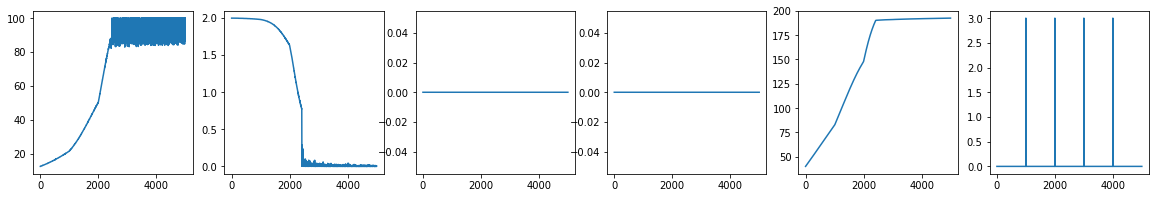

In [16]:
fig, axen = plt.subplots(1, 6, figsize=(20, 3))

axen[0].plot(obs[:, 0])
axen[1].plot(obs[:, 1])
axen[2].plot(rewards)
axen[3].plot(ends)
axen[4].plot(ds)
axen[5].plot(actions)

## moving down loses when electrode touches material

In [62]:
obs = [env.reset()]
ends = []
rewards = []
ds = []
for step in range(100):
    ob, reward, end, _ = env.step(1)
    obs.append(ob)
    rewards.append(reward)
    ends.append(end)
    ds.append(env.z_electrode - env.z_material)
    if end:
        break
    
obs = np.stack(obs)

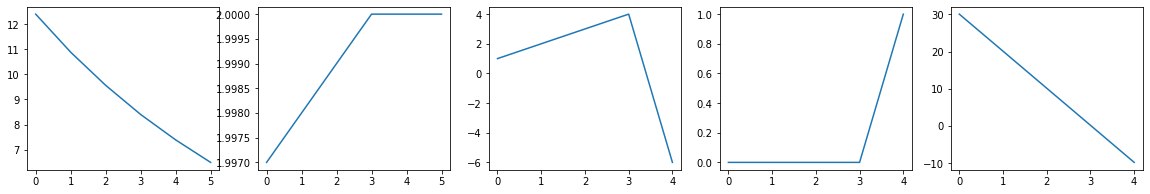

In [63]:
fig, axen = plt.subplots(1, 5, figsize=(20, 3))

axen[0].plot(obs[:, 0])
axen[1].plot(obs[:, 1])
axen[2].plot(np.cumsum(rewards))
axen[3].plot(ends)
axen[4].plot(ds)

## three strategies - good, too slow, and too fast

In [41]:
# advance_every = 100 # too fast - hits the material
advance_every = 159 # good
# advance_every = 201 # too slow - stops sparking

obs = [env.reset()]
ends = []
rewards = []
ds = []
actions = []
for step in range(1, 5000):
    
    if step % 1000 == 0:
        action = 3
    elif step % advance_every == 0:
        action = 1
    else:
        action = 0
    
    ob, reward, end, _ = env.step(action)    
    obs.append(ob)
    rewards.append(reward)
    ends.append(end)
    ds.append(env.z_electrode - env.z_material)
    actions.append(action)
    if end:
        break
    
obs = np.stack(obs)

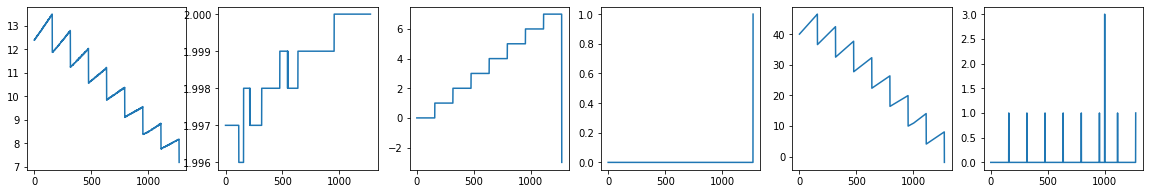

In [42]:
fig, axen = plt.subplots(1, 6, figsize=(20, 3))

axen[0].plot(obs[:, 0])
axen[1].plot(obs[:, 1])
axen[2].plot(np.cumsum(rewards))
axen[3].plot(ends)
axen[4].plot(ds)
axen[5].plot(actions)

0

Model

In [5]:
import torch
import numpy as np
from rlop.modules.edm_network import Network
from rlop.env.edm import NumpyEDM1
import matplotlib.pyplot as plt
import tqdm

In [6]:
model_fname = '/home/linas/Downloads/model_ep_1100.pt'

In [7]:
model = torch.load(model_fname, map_location=torch.device('cpu'))
model = model.eval()

In [8]:
env = NumpyEDM1(1)

In [49]:
obs = torch.tensor([env.reset()]).to(dtype=torch.float32)
ends = []
rewards = []
ds = []
obss = [obs]
actions = []
for _ in tqdm.trange(1000):
    distr = model(obs)[1]
    action = distr.sample().item()
    actions.append(action)
    obs, reward, end, _ = env.step(action)
    obs = torch.tensor([obs]).to(dtype=torch.float32)
    obss.append(obs)
    rewards.append(reward)
    ends.append(end)
    ds.append(env.z_electrode - env.z_material)
    obss.append(obs)
    
obss = torch.stack(obss)

100%|██████████| 1000/1000 [00:05<00:00, 188.76it/s]


(array([530.,   0.,   0., 142.,   0.,   0., 136.,   0.,   0., 192.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

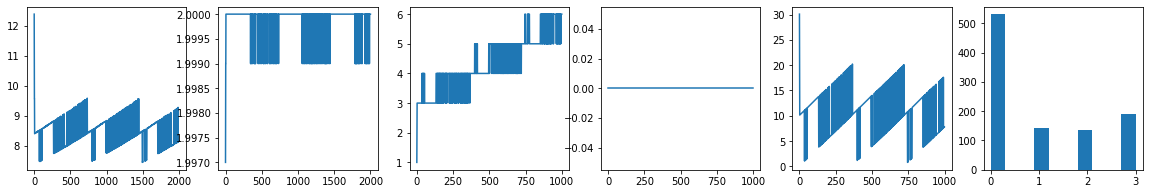

In [52]:
fig, axen = plt.subplots(1, 6, figsize=(20, 3))

axen[0].plot(obss[:, 0, 0])
axen[1].plot(obss[:, 0, 1])
axen[2].plot(np.cumsum(rewards))
axen[3].plot(ends)
axen[4].plot(ds)
axen[5].hist(actions)

In [51]:
obss.shape

torch.Size([2001, 1, 2])

In [47]:
distr.probs

tensor([[0., 1., 0., 0.]], grad_fn=<DivBackward0>)